### Проект по исследованию и предсказанию цен на новостройки на основе базы данных с ЦИАН

### Кодирование и нормализация признаков, обучение моделей

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [2]:
# Изменить текущую директорию на главную
os.chdir('..')

In [3]:
from src.set_params import set_params
from src.preprocessing import preprocessing, load_data, feature_encoding
from src.preprocessing import feature_encoding, all_features_encoding
from src.training import compare_models, check_model_on_valid, evaluate

### 1. Загрузка данных
---

In [4]:
params_path = 'params.yaml'
params = set_params(params_path)

In [5]:
data_all = load_data(params)
data_train, data_valid = train_test_split(data_all, test_size=0.25, shuffle=False)

X_train, y_train = preprocessing(data_train, params)
X_valid, y_valid = preprocessing(data_valid, params)

Для надежности будем использовать кросс-валидацию при оценивании результатов.

Данные зависят от даты обновления, но не зависят от предыдущих значений. Поэтому кросс-валидация на нескольких подвыборках не должна приводить к утечке данных из тестового в тренировочный набор.

Выделим поднабор для конечной валидации, а остальные данные будем использовать для тренировки моделей

---
### 2. Кодирование признаков и нормализация

In [6]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)

Категориальные признаки будет кодировать через one-hot кодирование, а числовые признаки преобразуе с помощью стандартного распределния

In [15]:
def fit_distance(x, a, b, c):
    return a * np.exp(-b * x) + c

p0 = (8.78223984e+06, 3.26351157e-03, 4.69136386e+06)

def get_fit_distance_params(x, y, p0):
    # X['Расстояние до метро']
    mask = ~x['Расстояние до метро'].isna()
    pars, _ = scipy.optimize.curve_fit(
        fit_distance, 
        xdata=x.loc[mask, 'Расстояние до метро'],  
        ydata=y[mask], 
        p0=p0)
    print(pars)
    
    return pars

# X['Стоимость от расстояния'] = X['Расстояние до метро'].map(
#     lambda x, pars=distance_params: fit_time_to_sub(x, *pars))

distance_params = get_fit_distance_params(X_train_, y_train_, p0)

X_train_['Расстояние до метро'].map(
    lambda x, pars=distance_params: fit_distance(x, *distance_params))

[7.73530591e+06 3.64714990e-03 5.46026283e+06]


22709    1.214555e+07
15594    1.178964e+07
15635    6.803608e+06
19592    5.557482e+06
26445    9.190102e+06
             ...     
1849     9.190102e+06
13847    1.123806e+07
22314    1.045376e+07
23665    1.167526e+07
8527     1.226858e+07
Name: Расстояние до метро, Length: 20386, dtype: float64

In [17]:
def fit_inflation(x, a, b):
    """Аппроксимация инфляции
    S[n] = a * ((1 + alpha)**n - 1) / (alpha)""" 
    return a * b ** (x)

p0 = (2.95919954e+06, 1.00425360e+00) # (1, 1)

def get_fit_inflation_params(X, y, p0):

    pars, _ = scipy.optimize.curve_fit(
        fit_inflation, 
        X['Дней'],  
        y, 
        p0=p0)
    print(pars)
    
    return pars

# X['Стоимость с инфляцией'] = X['Дней'].map(
#     lambda row: fit_month_year(row, *inflation_params))
inflation_params = get_fit_inflation_params(X_train_, y_train_, p0)

X_train_['Дней'].map(
    lambda row: fit_inflation(row, *inflation_params))

[2.42907108e+06 1.00489665e+00]


22709    9.773252e+06
15594    9.171934e+06
15635    9.631078e+06
19592    8.318268e+06
26445    1.120568e+07
             ...     
1849     9.631078e+06
13847    9.631078e+06
22314    9.631078e+06
23665    9.398702e+06
8527     9.444725e+06
Name: Дней, Length: 20386, dtype: float64

---

In [8]:
cat_features = ['Парковка', 'Тип дома']
num_features = X_train.select_dtypes(include=np.number).columns

X_train_, X_test_, X_valid_ = all_features_encoding(X_train_, X_test_, X_valid, cat_features, num_features)

### 3. Простое сравнение различных моделей

C:\Users\petro\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


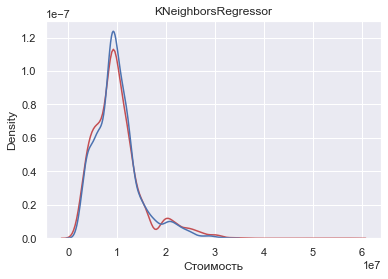

KNeighborsRegressor finished


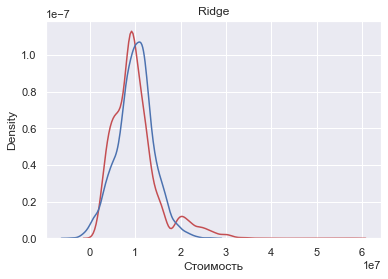

Ridge finished


C:\Users\petro\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.844e+14, tolerance: 5.632e+13
  model = cd_fast.enet_coordinate_descent(


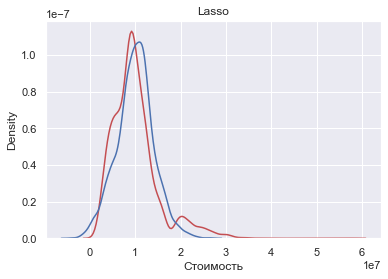

Lasso finished


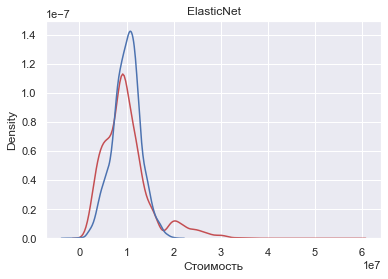

ElasticNet finished


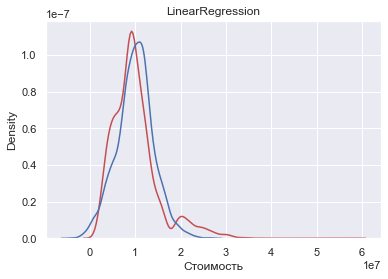

LinearRegression finished


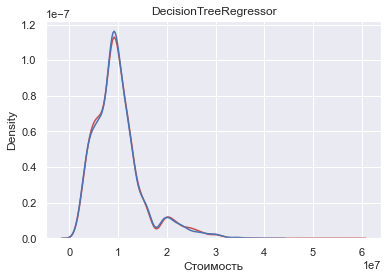

DecisionTreeRegressor finished


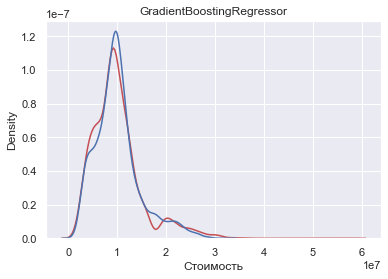

GradientBoostingRegressor finished


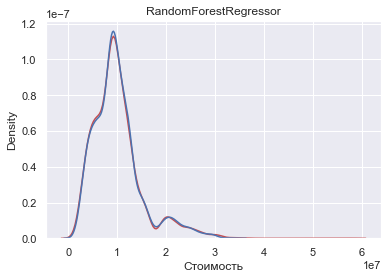

RandomForestRegressor finished


In [10]:
list_of_models = [
    KNeighborsRegressor, Ridge, Lasso, ElasticNet, LinearRegression, 
    DecisionTreeRegressor, GradientBoostingRegressor, RandomForestRegressor
]

df_scores = compare_models(X_train_, y_train_, X_test_, y_test_, 
                           models=list_of_models)

In [11]:
df_scores

,model,mae,mse,rmse,r2_square
0,KNeighborsRegressor,1.116080e+06,4.659729e+12,2.158641e+06,0.825846
1,Ridge,2.311339e+06,1.049385e+13,3.239421e+06,0.607800
2,Lasso,2.311395e+06,1.049384e+13,3.239420e+06,0.607800
3,ElasticNet,2.466654e+06,1.264194e+13,3.555550e+06,0.527517
4,LinearRegression,2.311396e+06,1.049384e+13,3.239420e+06,0.607800
5,DecisionTreeRegressor,6.713714e+05,2.492217e+12,1.578676e+06,0.906855
6,GradientBoostingRegressor,1.160808e+06,3.353812e+12,1.831342e+06,0.874654
7,RandomForestRegressor,5.248336e+05,1.303935e+12,1.141900e+06,0.951266


#### RandomForestRegressor

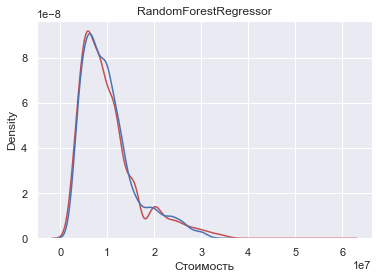

,mae,mse,rmse,r2_square
0,1.290831e+06,5.454297e+12,2.335444e+06,0.859585
7,5.248336e+05,1.303935e+12,1.141900e+06,0.951266


In [13]:
model = RandomForestRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_valid_scores.append(df_scores[df_scores.model == model.__name__][df_valid_scores.columns])

#### GradientBoostingRegressor

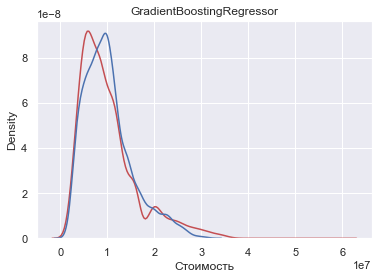

,mae,mse,rmse,r2_square
0,1.643377e+06,6.918455e+12,2.630296e+06,0.821892
6,1.160808e+06,3.353812e+12,1.831342e+06,0.874654


In [14]:
model = GradientBoostingRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_valid_scores.append(df_scores[df_scores.model == model.__name__][df_valid_scores.columns])

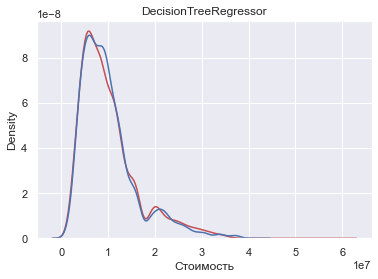

,mae,mse,rmse,r2_square
0,1.697304e+06,9.661449e+12,3.108287e+06,0.751276
5,6.713714e+05,2.492217e+12,1.578676e+06,0.906855


In [15]:
model = DecisionTreeRegressor
df_valid_scores = check_model_on_valid(model, X_train_, y_train_, X_valid_, y_valid)
df_valid_scores.append(df_scores[df_scores.model == model.__name__][df_valid_scores.columns])

Большей обобщающей способностью обладает RandomForestRegressor, при этом у GradientBoostingRegressor меньше падает оценка предсказания. Возможно, GradientBoostingRegressor будет более устойчивой модельню со временем. 

### Настройка лучших моделей

In [ ]:
# X_train_, X_test_, y_train_, y_test_

In [17]:
from sklearn.model_selection import GridSearchCV

estimator = RandomForestRegressor(n_jobs=-1)
param_grid = {
    "n_estimators": [100, 210],
#     "min_samples_leaf": [2, 4, 8],
#     "max_features": ["sqrt"],
#     "min_samples_split" : [2, 6, 12],
#     "max_depth": [5, 10, 17],
    }

grid = GridSearchCV(estimator, param_grid, n_jobs=-1)
grid.fit(X_train_, y_train_)

y_pred = grid.best_estimator_.predict(X_test_)

print(
    metrics.mean_absolute_error(y_test_, y_pred), '\n', 
    metrics.mean_squared_error(y_test_, y_pred), '\n', 
    np.sqrt(metrics.mean_squared_error(y_test_, y_pred)), '\n',
    metrics.r2_score(y_test_, y_pred)
)

525747.3362804968 
 1323000035511.8652 
 1150217.3861978722 
 0.950553827348834


In [31]:
y_pred = grid.best_estimator_.predict(X_valid_)
y_true = y_valid

df_valid_scores = pd.DataFrame(np.reshape(evaluate(y_true, y_pred), (1, -1)),
                           columns=['mae','mse','rmse','r2_square'])
model_name = 'RandomForestRegressor'
df_test_scores = df_scores[df_scores.model == model_name][df_valid_scores.columns]
df_test_scores = df_test_scores.append(df_valid_scores)
df_test_scores[model_name] = ['test', 'valid']
df_test_scores

,mae,mse,rmse,r2_square,RandomForestRegressor
7,5.248336e+05,1.303935e+12,1.141900e+06,0.951266,test
0,1.265352e+06,5.349633e+12,2.312927e+06,0.862279,valid


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=tscv)
grid.fit(x_train_choosen, y_train_choosen)

y_pred = grid.best_estimator_.predict(x_test_choosen)

print(
    metrics.mean_absolute_error(y_test_choosen, y_pred), '\n', 
    metrics.mean_squared_error(y_test_choosen, y_pred), '\n', 
    np.sqrt(metrics.mean_squared_error(y_test_choosen, y_pred)), '\n',
    metrics.r2_score(y_test_choosen, y_pred)
)